# Probabilidad de compra de un producto específico utilizando Escalamiento y un modelo MLP


## 1. Exploración y preprocesamiento de datos:

Cargamos los datos

Observando que los delimitadores están conformados por "\" hemos especificado el parametro "delimiter"

In [444]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
ds_path = "data/marketing_campaign.csv"
df = pd.read_csv(ds_path, delimiter="\t")


Visualizamos la cabecera

In [445]:
df.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


Exploramos los datos

In [446]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Se observan tipos de datos que pueden ser ajustados.

A continuacion, convertimos Dt_CUstomer a tipo de dato Datetime

In [447]:
from datetime import datetime

def _convert_date(x):
    if pd.isna(x) or pd.isnull(x):
        return x
    try:
        return datetime.strptime(x, "%d-%m-%Y")
    except Exception:
        print(f"Fallo para valor: {x}")
        return x

df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"].apply(_convert_date), utc=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   ID                   2240 non-null   int64              
 1   Year_Birth           2240 non-null   int64              
 2   Education            2240 non-null   object             
 3   Marital_Status       2240 non-null   object             
 4   Income               2216 non-null   float64            
 5   Kidhome              2240 non-null   int64              
 6   Teenhome             2240 non-null   int64              
 7   Dt_Customer          2240 non-null   datetime64[ns, UTC]
 8   Recency              2240 non-null   int64              
 9   MntWines             2240 non-null   int64              
 10  MntFruits            2240 non-null   int64              
 11  MntMeatProducts      2240 non-null   int64              
 12  MntFishProducts     

Observamos los valores unicos de las variables categóricas

In [448]:
from utils.eda import get_categoric_columns
categoric_columns = get_categoric_columns(df)
for i in categoric_columns:
    print(i)
    print(df[i].unique())

Education
['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


Vemos valores atipicos como Absurd y Yolo, mas adelante nos encargaremos de esos valores

Continuamos con la exploración de los datos

Visualizamos las últimas entradas

In [449]:
df.tail(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2230,7004,1984,Graduation,Single,11012.0,1,0,2013-03-16 00:00:00+00:00,82,24,...,9,1,0,0,0,0,0,3,11,0
2231,9817,1970,Master,Single,44802.0,0,0,2012-08-21 00:00:00+00:00,71,853,...,8,0,0,0,0,0,0,3,11,0
2232,8080,1986,Graduation,Single,26816.0,0,0,2012-08-17 00:00:00+00:00,50,5,...,4,0,0,0,0,0,0,3,11,0
2233,9432,1977,Graduation,Together,666666.0,1,0,2013-06-02 00:00:00+00:00,23,9,...,6,0,0,0,0,0,0,3,11,0
2234,8372,1974,Graduation,Married,34421.0,1,0,2013-07-01 00:00:00+00:00,81,3,...,7,0,0,0,0,0,0,3,11,0
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13 00:00:00+00:00,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10 00:00:00+00:00,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25 00:00:00+00:00,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24 00:00:00+00:00,8,428,...,3,0,0,0,0,0,0,3,11,0
2239,9405,1954,PhD,Married,52869.0,1,1,2012-10-15 00:00:00+00:00,40,84,...,7,0,0,0,0,0,0,3,11,1


Verificamos los valores descriptivos

In [450]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


Se observa que para las columnas Z_COstContact y Z_Revenue la desviacion estandar es 0, por lo tanto deben tratarse de valores constantes para todos los registros del dataset. Estas columnas pueden descartarse ya que no aportaran informacion util al modelo.

In [451]:
df.drop(['Z_Revenue','Z_CostContact'],axis=1,inplace=True)

Continuamos con el analisis

In [452]:
df.describe(include='object').T

,count,unique,top,freq
Education,2240,5,Graduation,1127
Marital_Status,2240,8,Married,864


Ahora reduciremos el numero de opciones para las columnas categoricas a fin de tener una mejor respuesta del modelo y simplificar la entrada.

In [453]:
from utils.eda import get_categoric_columns
categoric_columns = get_categoric_columns(df)
for i in categoric_columns:
    print(i)
    print(df[i].unique())

df['Marital_Status'].value_counts()

Education
['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


,count
Marital_Status,
Married,864
Together,580
Single,480
Divorced,232
Widow,77
Alone,3
Absurd,2
YOLO,2


- En Education, reduciremos a las categorias: Pre-universitaria (undergraduate) ,Graduation, Master, PhD
- En Marital_Status simplificaremos a: Soltero, Acompanhado, Divorciado, Casado y Viudo (Eliminaremos las entradas YOLO y Absurd por tratarse de datos erroneos y poco recurrentes)

In [454]:
df.loc[
    (df['Education'] == 'Basic') | (df['Education'] == '2n Cycle'),
    'Education'
] = 'Undergraduate'
drop_entries = df[(df['Marital_Status'] == 'Absurd') | (df['Marital_Status'] == 'YOLO')].index
df.drop(index=drop_entries, inplace=True)
df.loc[df.Marital_Status == 'Alone', 'Marital_Status'] = "Single"
df.describe(include='object').T

,count,unique,top,freq
Education,2236,4,Graduation,1126
Marital_Status,2236,5,Married,864


Ahora las columnas categoricas son mas claras y el modelo podra ser generado con mejor respuesta

### Identificación de valores nulos, duplicados y outliers

In [455]:
duplicated = df.duplicated().sum()
print(f"Registros duplicados en df: {duplicated}")

Registros duplicados en df: 0


No se observan valores duplicados

Ahora observaremos la columna ID

In [456]:
df['ID'].duplicated().sum()

0

No se observan duplicados por lo tanto cada ID posee solo una entrada, por lo tanto podemos eliminar dicha columna ya que no aporta informacion importante al modelo

In [457]:
df.drop(['ID'],axis=1,inplace=True)

Volvemos a verificar si existen valores duplicados ahora que eliminamos la columna ID. Ya que pueden existir entradas de diferentes clientes que sean identicas.

In [458]:
duplicated = df.duplicated().sum()
print(f"Registros duplicados en df: {duplicated}")

Registros duplicados en df: 183


Observamos que existen registros duplicados, por lo tanto eliminamos estas entradas que podrian ocasionar overfitting en nuestro modelo.

In [459]:
df = df.drop_duplicates()
duplicated = df.duplicated().sum()
print(f"Registros duplicados en df: {duplicated}")

Registros duplicados en df: 0


Ahora buscamos valores nulos

In [460]:
from utils.eda import get_nulll_data_info
get_nulll_data_info(df)

,datos sin NAs en q,Na en q,Na en %
Income,2029,24,1.17
Year_Birth,2053,0,0.00
NumDealsPurchases,2053,0,0.00
Complain,2053,0,0.00
AcceptedCmp2,2053,0,0.00
AcceptedCmp1,2053,0,0.00
AcceptedCmp5,2053,0,0.00
AcceptedCmp4,2053,0,0.00
AcceptedCmp3,2053,0,0.00
NumWebVisitsMonth,2053,0,0.00


Se observan 24 valores nulos. Procederemos a imputarlos por el valor promedio. Ya que se trata del ingreso del cliente y el valor promedio es un metodo adecuado.

In [461]:
df.loc[:, 'Income'] = df['Income'].fillna(df['Income'].mean())
get_nulll_data_info(df)

,datos sin NAs en q,Na en q,Na en %
Year_Birth,2053,0,0.0
Education,2053,0,0.0
Complain,2053,0,0.0
AcceptedCmp2,2053,0,0.0
AcceptedCmp1,2053,0,0.0
AcceptedCmp5,2053,0,0.0
AcceptedCmp4,2053,0,0.0
AcceptedCmp3,2053,0,0.0
NumWebVisitsMonth,2053,0,0.0
NumStorePurchases,2053,0,0.0


Ahora crearemos una nueva columna para contar la cantidad de hijos de cada cliente

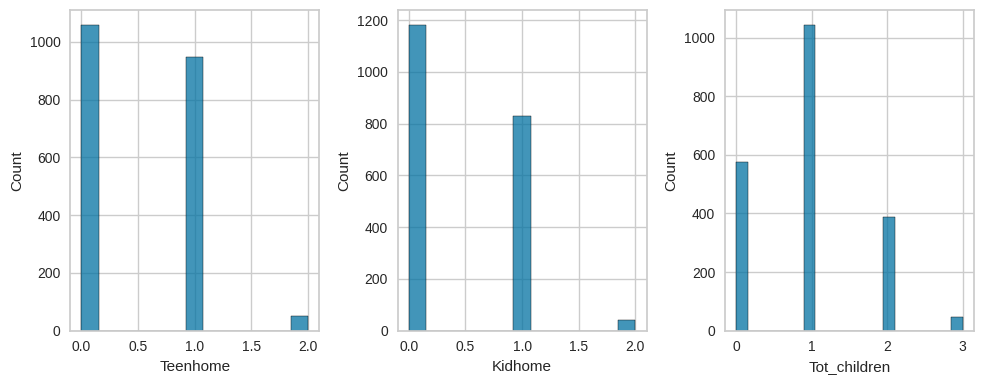

In [462]:
df.loc[:, 'Tot_children'] = df['Teenhome'] + df['Kidhome']

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,4))

sns.histplot(df['Teenhome'],ax=axes[0])
sns.histplot(df['Kidhome'],ax=axes[1])
sns.histplot(df['Tot_children'],ax=axes[2])
plt.tight_layout()
plt.show()

Observaremos el rango etario de los clientes

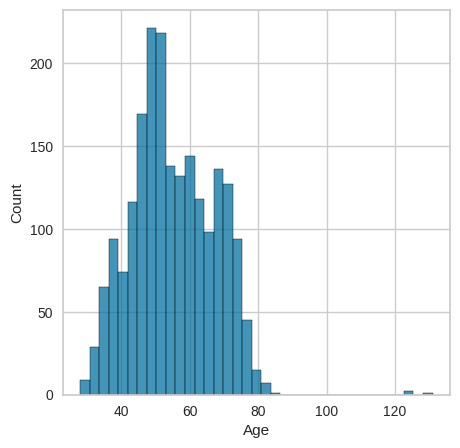

In [463]:
df['Age'] = 2024-df['Year_Birth']
plt.figure(figsize=(5,5))
sns.histplot(df['Age'])
plt.show()

Observamos outliers que indican edades mas alla de 120 anhos, lo cual es altamente probable de que se trate de un error, eliminamos dichas entradas

In [464]:
# removemos outliers
df['Age'] = df['Age'].clip(upper=81)

Agrupamos y volvemos a observar en un histograma

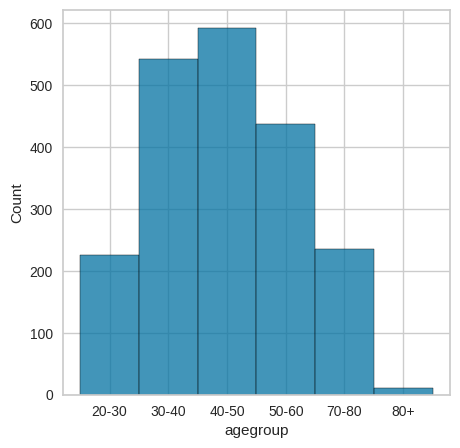

In [465]:
bins=[30,40,50,60,70,80,90]
labels = ['20-30','30-40','40-50','50-60','70-80','80+']

df['agegroup'] = pd.cut(df['Age'],bins=bins,labels=labels)
plt.figure(figsize=(5,5))
sns.histplot(df['agegroup'])
plt.show()

Creamos un feature con los datos totales de gastos

In [466]:
df['Tot_Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

Creamos un feature con los datos totales en cupones

In [467]:
df['Tot_AcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']

Y creamos otro feature con las compras totales por tipo de compra

In [468]:
df['Tot_Purchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

Generamos Histogramas para visualizar la distribucion

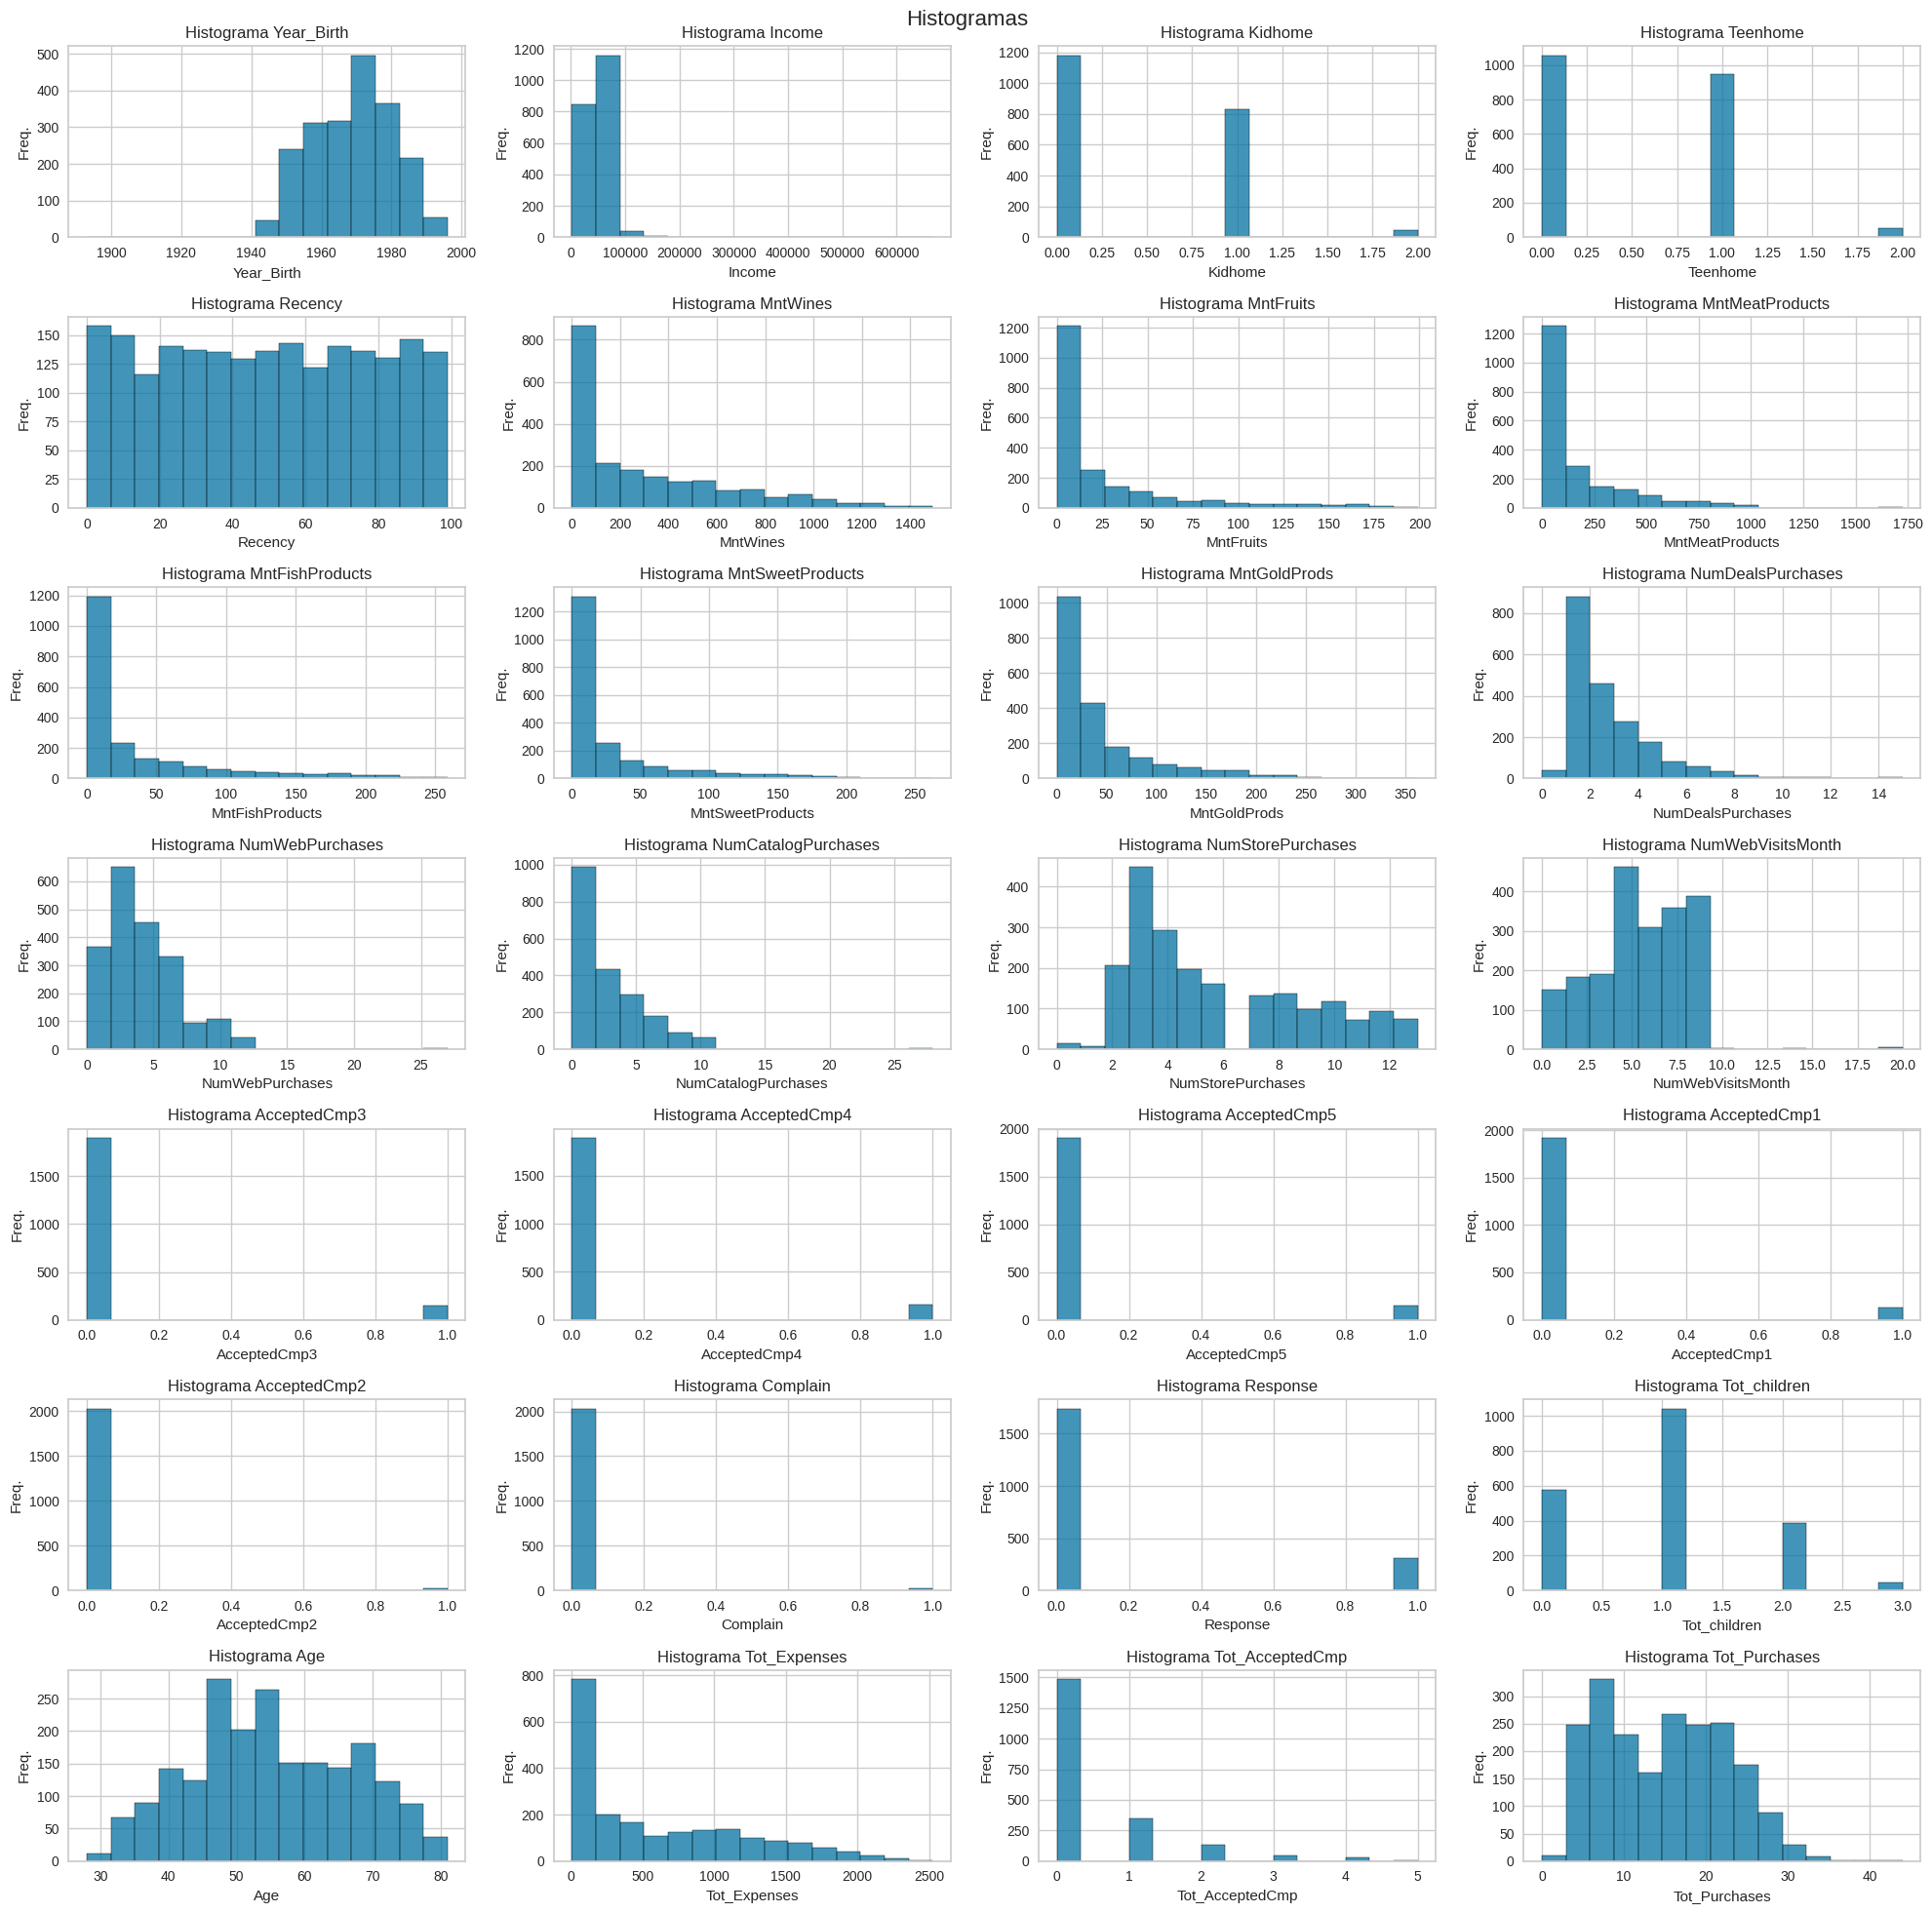

In [469]:
from utils.eda import graph_histogram, get_numeric_columns
graph_histogram(df, get_numeric_columns(df), bins=15, columns_number=4, figsize=(20, 20))

No se observa nada fuera de lo normal en los histogramas

Ahora verificamos los outliers

In [470]:
from utils.eda import get_outliers_data
get_outliers_data(df)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Tot_children,Age,Tot_Expenses,Tot_AcceptedCmp,Tot_Purchases
N° Outliers,3.000000,8.000000,0.0,0.0,0.0,33.000000,206.000000,173.000000,201.00000,221.000000,...,147.000000,134.000000,26.000000,20.000000,311.000000,48.000000,0.0,3.000000,88.00000,2.000000
% Outliers,0.146128,0.389674,0.0,0.0,0.0,1.607404,10.034096,8.426693,9.79055,10.764735,...,7.160253,6.527034,1.266439,0.974184,15.148563,2.338042,0.0,0.146128,4.28641,0.097418
Lim. mix,1932.000000,-13158.500000,-1.5,-1.5,-51.0,-700.000000,-47.000000,-305.000000,-67.50000,-48.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.500000,20.0,-1397.500000,-1.50000,-11.500000
Lim. max,2004.000000,117133.500000,2.5,2.5,149.0,1228.000000,81.000000,551.000000,120.50000,83.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,92.0,2510.500000,2.50000,40.500000


Visualizamos las gráficas de cajas de nuestras columnas

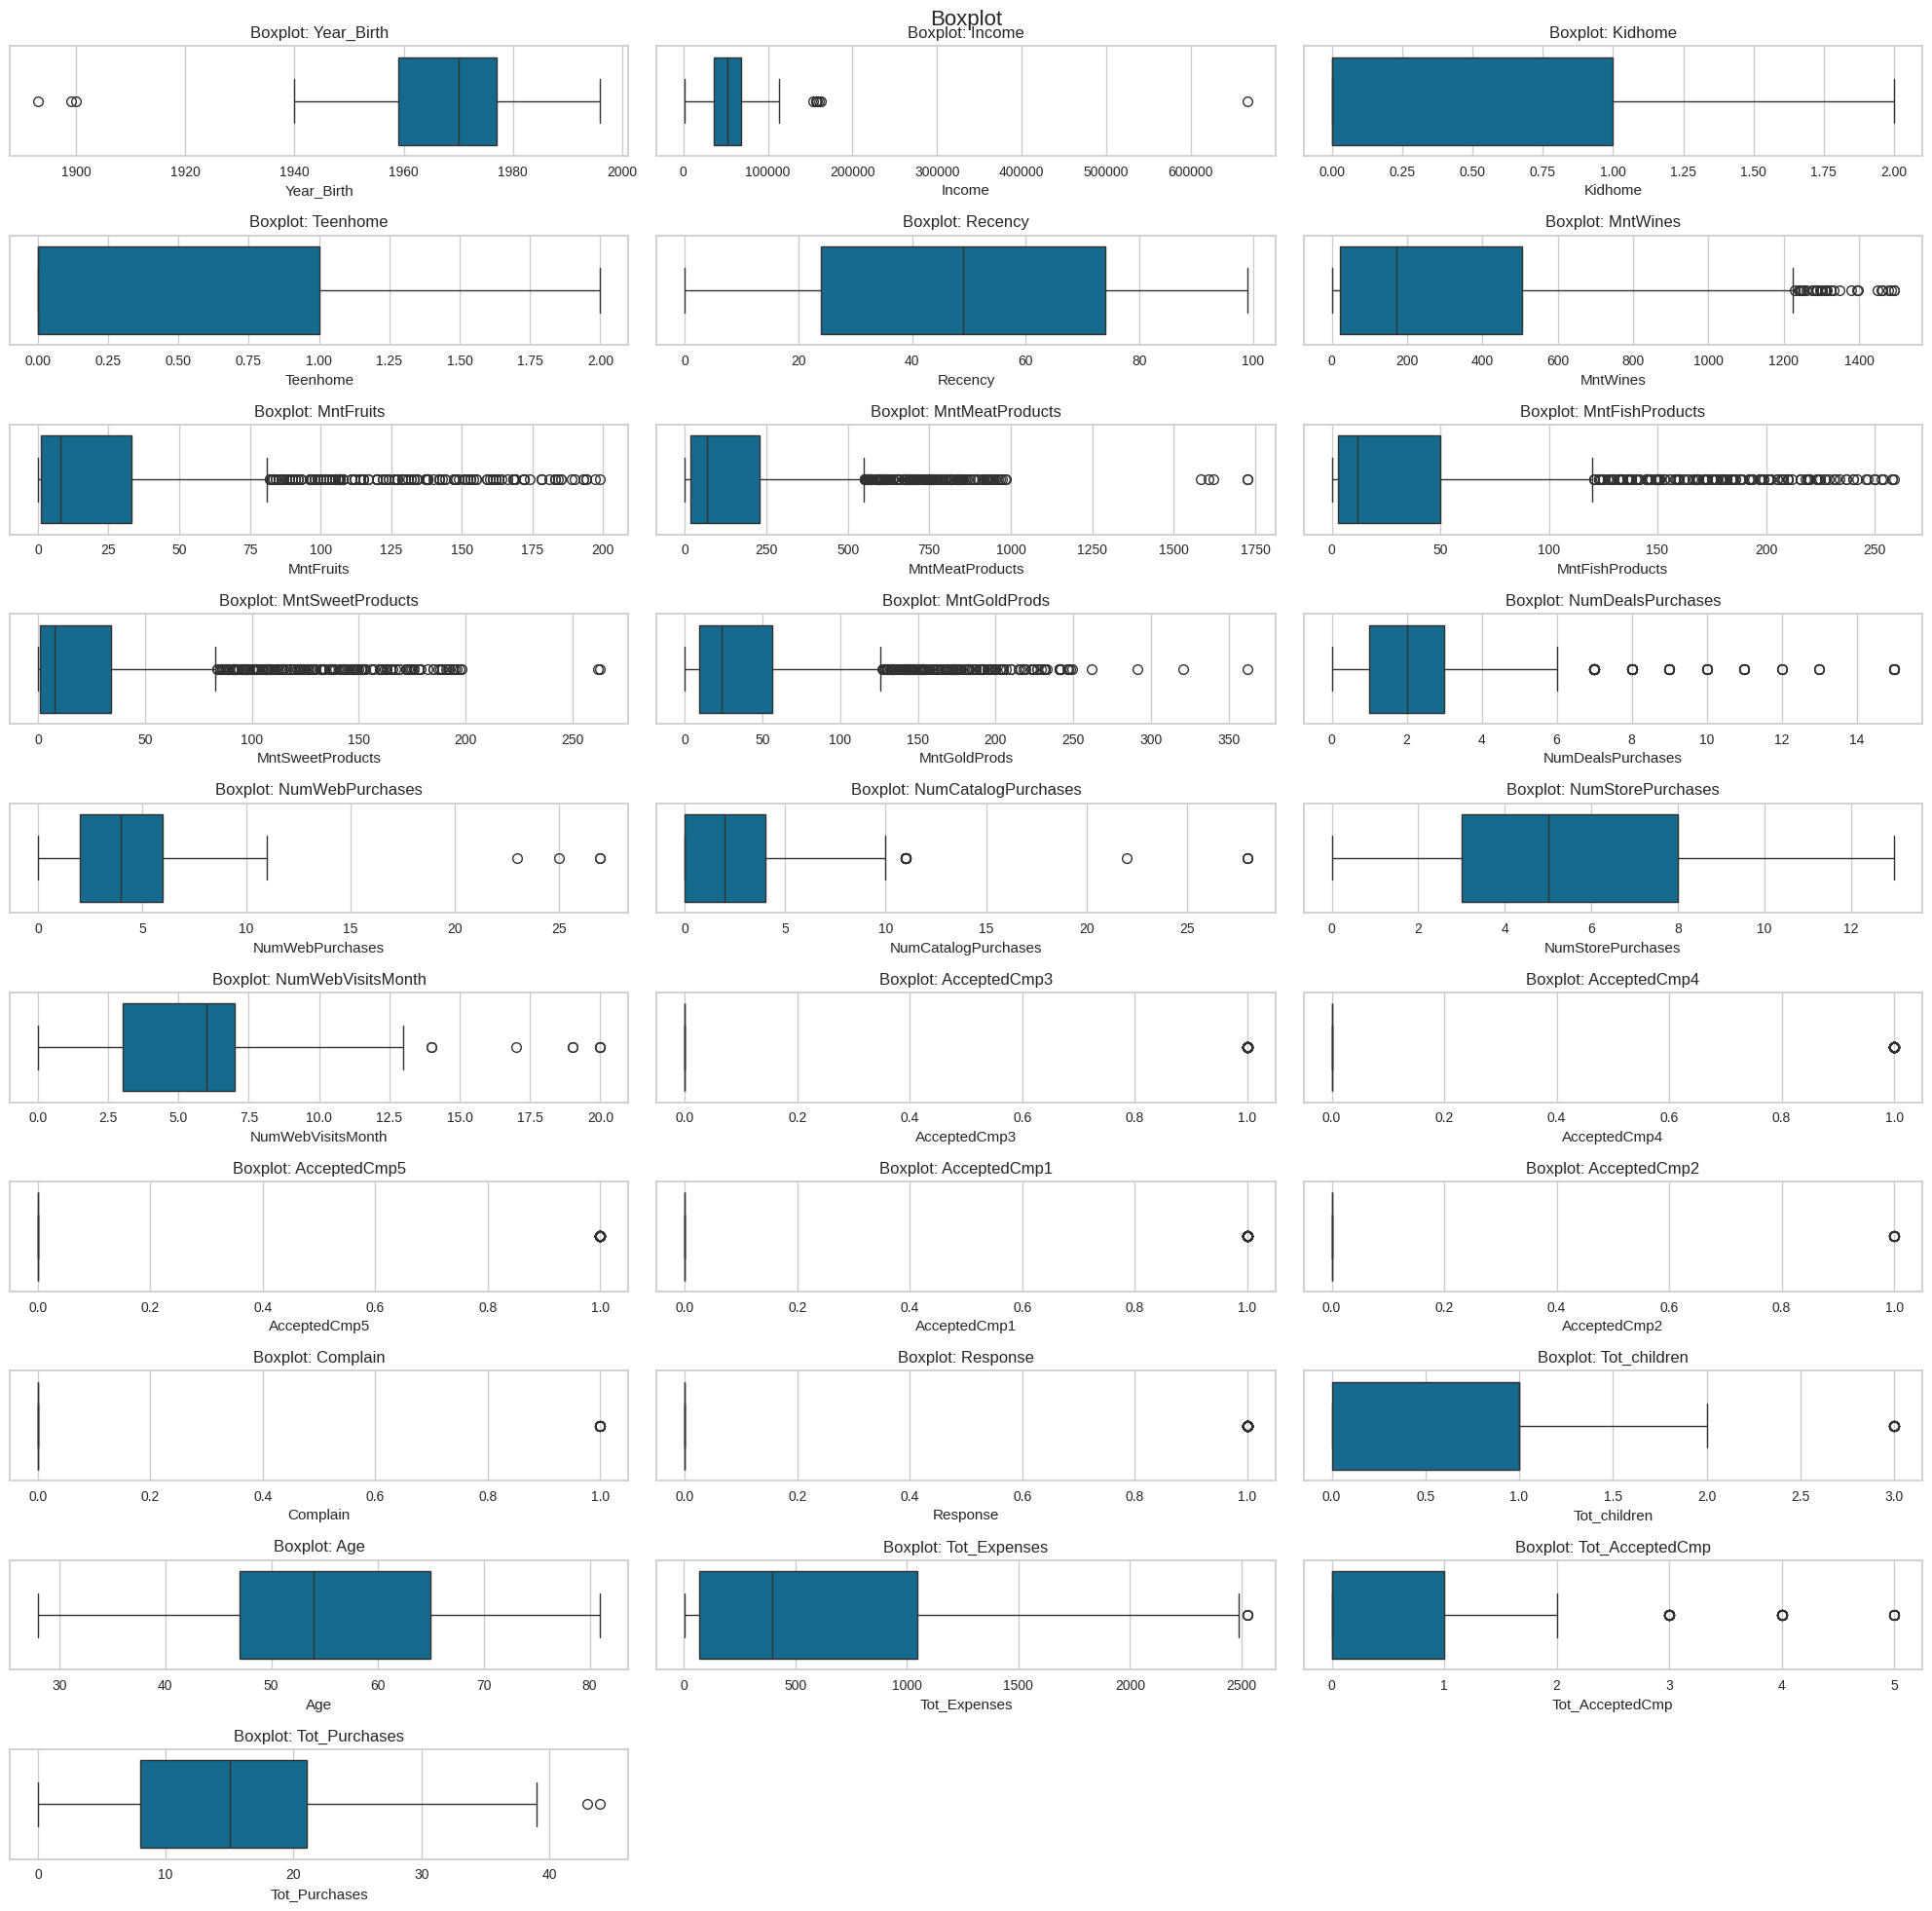

In [471]:
from utils.eda import graph_boxplot, get_numeric_columns
graph_boxplot(df, columns=get_numeric_columns(df), figsize=(20, 20))

Observamos algunos outliers

Ahora veremos las caracteristicas descriptivas de las variables númericas

In [472]:
df.describe()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Tot_children,Age,Tot_Expenses,Tot_AcceptedCmp,Tot_Purchases
count,2053.000000,2053.000000,2053.000000,2053.000000,2053.000000,2053.000000,2053.000000,2053.000000,2053.000000,2053.000000,...,2053.000000,2053.000000,2053.000000,2053.000000,2053.000000,2053.000000,2053.000000,2053.000000,2053.000000,2053.00000
mean,1968.767657,52350.900444,0.446176,0.509498,49.010716,303.999513,26.209937,167.748173,37.207014,27.203604,...,0.071603,0.065270,0.012664,0.009742,0.151486,0.955675,55.163176,606.098880,0.451534,14.86264
std,11.965475,25396.446917,0.537712,0.546594,28.986804,336.849714,39.744889,228.409947,54.459371,41.745965,...,0.257891,0.247062,0.111849,0.098243,0.358609,0.748932,11.684705,603.159304,0.890284,7.66944
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,5.000000,0.000000,0.00000
25%,1959.000000,35701.000000,0.000000,0.000000,24.000000,23.000000,1.000000,16.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,68.000000,0.000000,8.00000
50%,1970.000000,52074.000000,0.000000,0.000000,49.000000,173.000000,8.000000,67.000000,12.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,54.000000,396.000000,0.000000,15.00000
75%,1977.000000,68274.000000,1.000000,1.000000,74.000000,505.000000,33.000000,230.000000,50.000000,34.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,65.000000,1045.000000,1.000000,21.00000
max,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,81.000000,2525.000000,5.000000,44.00000


In [473]:
from utils.eda import get_descriptive_statistics
get_descriptive_statistics(df)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Tot_children,Age,Tot_Expenses,Tot_AcceptedCmp,Tot_Purchases
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,5.000000,0.000000,0.000000
max,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,81.000000,2525.000000,5.000000,44.000000
mean,1968.767657,52350.900444,0.446176,0.509498,49.010716,303.999513,26.209937,167.748173,37.207014,27.203604,...,0.071603,0.065270,0.012664,0.009742,0.151486,0.955675,55.163176,606.098880,0.451534,14.862640
std,11.965475,25396.446917,0.537712,0.546594,28.986804,336.849714,39.744889,228.409947,54.459371,41.745965,...,0.257891,0.247062,0.111849,0.098243,0.358609,0.748932,11.684705,603.159304,0.890284,7.669440
median,1970.000000,52074.000000,0.000000,0.000000,49.000000,173.000000,8.000000,67.000000,12.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,54.000000,396.000000,0.000000,15.000000
variation_coefficient,0.006078,0.485120,1.205155,1.072807,0.591438,1.108060,1.516405,1.361624,1.463686,1.534575,...,3.601709,3.785218,8.831734,10.084619,2.367280,0.783669,0.211821,0.995150,1.971687,0.516021


Ahora visualizaremos graficos de barra columnas relevantes, las cuales han sido modificadas anteriormente

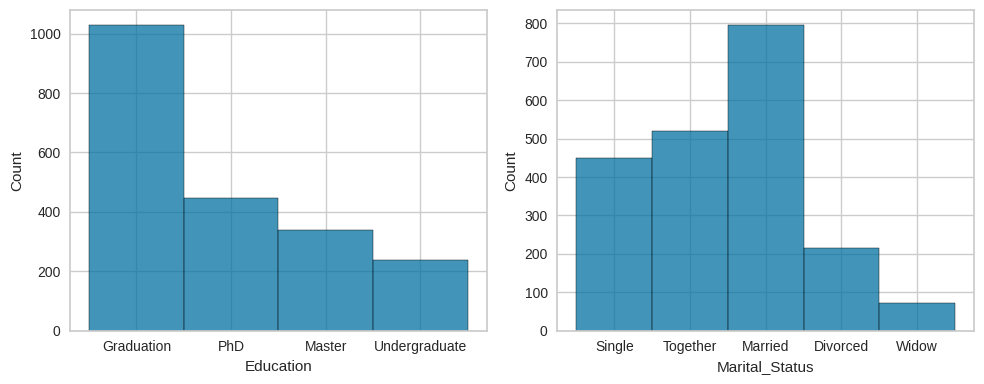

In [474]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))

sns.histplot(df['Education'],ax=axes[0])
sns.histplot(df['Marital_Status'],ax=axes[1])

plt.tight_layout()
plt.show()

Vemos que se ha reducido la cantidad de valores categoricos unicos para ambos features

Veremos las correlaciones entre las caracteristicas

In [475]:
from utils.eda import get_numeric_columns
numeric_columns = get_numeric_columns(df)
corr_matrix = df[numeric_columns].corr(method="pearson")
spearmann = df[numeric_columns].corr(method="spearman")
kendall = df[numeric_columns].corr(method="kendall")
corr_matrix

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Tot_children,Age,Tot_Expenses,Tot_AcceptedCmp,Tot_Purchases
Year_Birth,1.000000,-0.161259,0.241456,-0.352218,-0.019727,-0.164427,-0.029775,-0.033933,-0.045933,-0.022770,...,0.007447,0.006946,0.000379,-0.025849,0.023652,-0.083701,-0.989323,-0.117346,0.015389,-0.168619
Income,-0.161259,1.000000,-0.425117,0.019610,-0.009385,0.561798,0.419160,0.566069,0.428075,0.426090,...,0.327467,0.271078,0.085200,-0.026550,0.129063,-0.290910,0.163219,0.650259,0.279912,0.549862
Kidhome,0.241456,-0.425117,1.000000,-0.045930,0.016170,-0.503243,-0.371992,-0.437269,-0.387099,-0.368038,...,-0.209409,-0.182637,-0.085896,0.037606,-0.082796,0.684450,-0.245679,-0.561246,-0.202179,-0.483694
Teenhome,-0.352218,0.019610,-0.045930,1.000000,0.023400,0.006258,-0.177297,-0.259914,-0.195008,-0.162570,...,-0.186329,-0.141724,-0.025882,-0.001724,-0.157760,0.696854,0.362386,-0.136908,-0.159536,0.126908
Recency,-0.019727,-0.009385,0.016170,0.023400,1.000000,0.011055,-0.012217,0.013112,-0.002313,0.019437,...,-0.004079,-0.024731,-0.009511,0.007151,-0.202919,0.028688,0.019520,0.012273,-0.094286,0.003196
MntWines,-0.164427,0.561798,-0.503243,0.006258,0.011055,1.000000,0.388262,0.555376,0.397172,0.379920,...,0.465964,0.357275,0.199531,-0.037772,0.238826,-0.356746,0.169108,0.889859,0.482366,0.709734
MntFruits,-0.029775,0.419160,-0.371992,-0.177297,-0.012217,0.388262,1.000000,0.541203,0.591956,0.555469,...,0.217002,0.202926,-0.004983,-0.002147,0.129029,-0.396476,0.027388,0.613635,0.178552,0.451155
MntMeatProducts,-0.033933,0.566069,-0.437269,-0.259914,0.013112,0.555376,0.541203,1.000000,0.563551,0.517030,...,0.372540,0.317207,0.045773,-0.021869,0.238396,-0.503640,0.034209,0.840761,0.330173,0.550293
MntFishProducts,-0.045933,0.428075,-0.387099,-0.195008,-0.002313,0.397172,0.591956,0.563551,1.000000,0.582155,...,0.189509,0.261841,0.003650,-0.018503,0.104121,-0.420249,0.046996,0.640540,0.170169,0.470279
MntSweetProducts,-0.022770,0.426090,-0.368038,-0.162570,0.019437,0.379920,0.555469,0.517030,0.582155,1.000000,...,0.255439,0.249230,0.012911,-0.020922,0.117993,-0.382889,0.024191,0.598733,0.198065,0.469922


Ahora graficamos el mapa de calor de las correlaciones

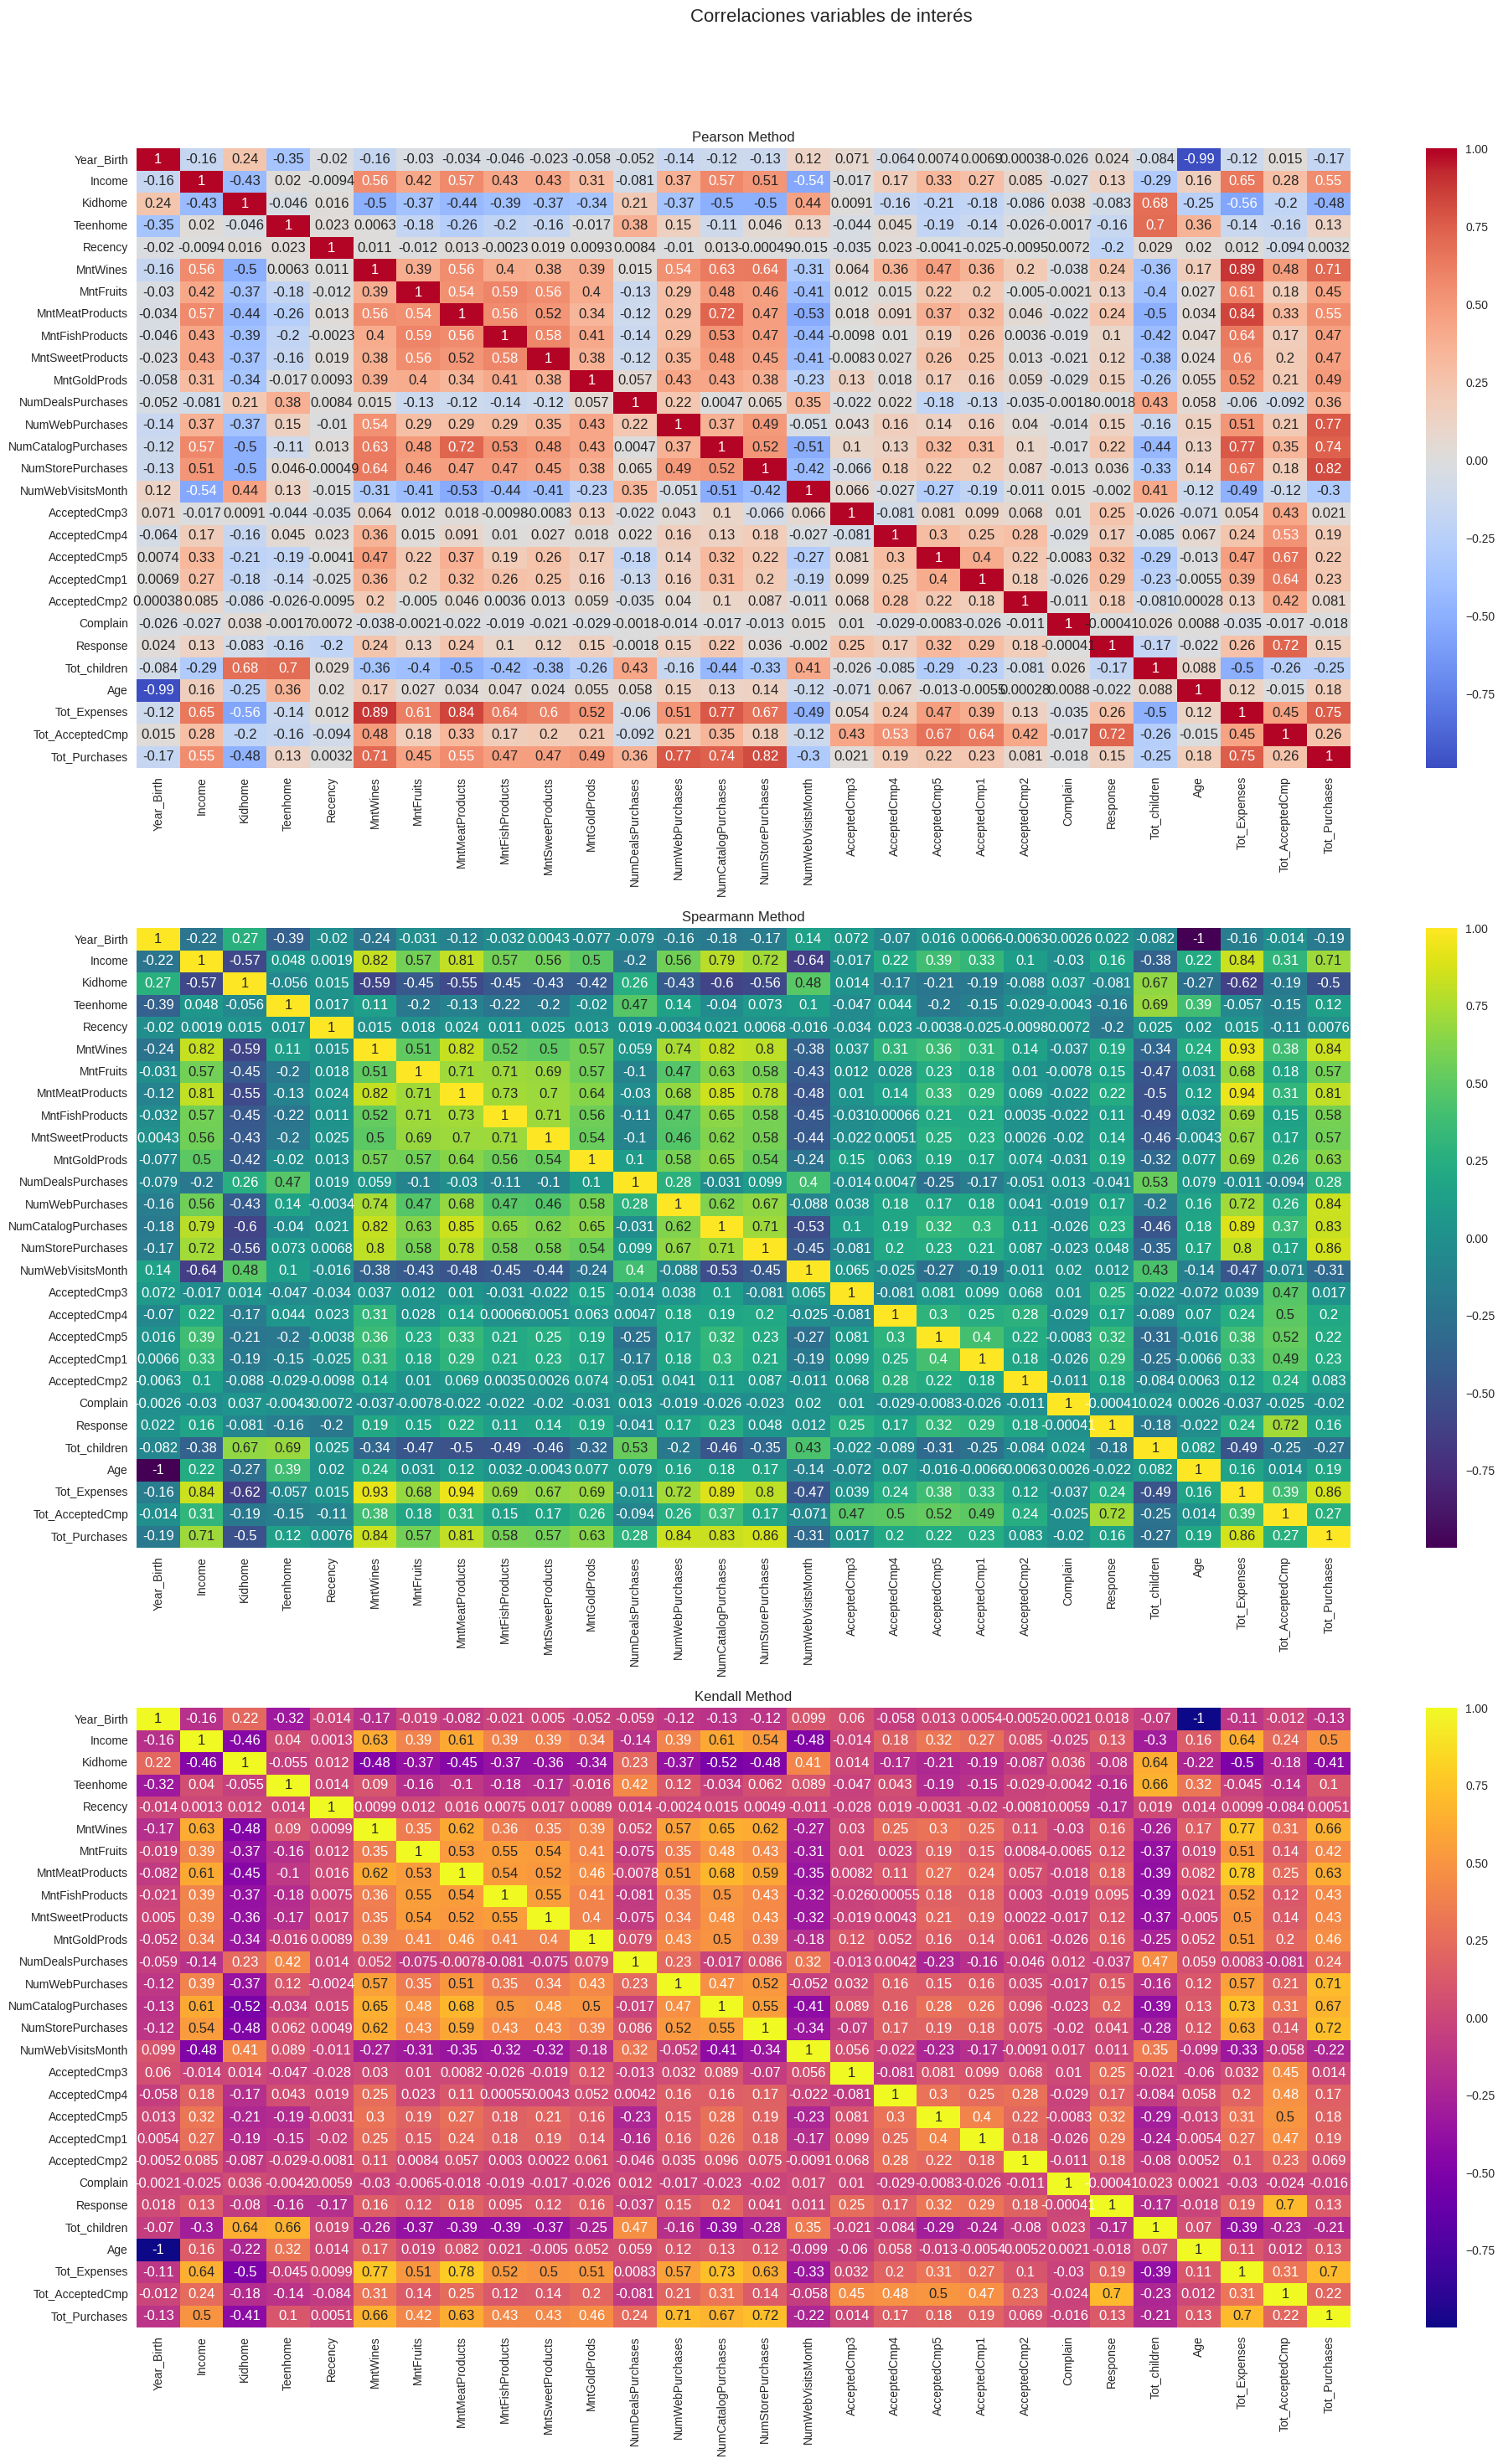

In [476]:
from utils.eda import graph_correlations
graph_correlations(corr_matrix, spearmann, kendall, "Correlaciones variables de interés", figsize= (20,30))

Vemos que existen muchas correlaciones importantes, por ejemplo las existentes entre MntMeats MntFruits, MntSweet etc.

## Modelado MLP

Implementa un Perceptrón Multicapa (MLP) para predecir las compras futuras de los clientes o su probabilidad de realizar una compra en una categoría específica de productos.

**Objetivo:**

Predecir las compras futuras: basado en datos históricos de los clientes (como compras anteriores, categorías favoritas, frecuencia de compra, etc.), el modelo debe ser capaz de anticipar si un cliente comprará en el futuro.

### Implementamos un MLP

In [477]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Métricas
# Evaluación
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

Inicializamos el modelo y le agregamos las caracteristicas (capas, activadores, etc)

In [478]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Crear variable binaria para la categoría de producto seleccionada ("MntMeatProducts")
df['MntSweetProducts_Buy'] = (df['MntSweetProducts'] > 0).astype(int)

# Características predictoras (puedes ajustarlas según tu análisis)
X = df[['Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
         'NumStorePurchases', 'NumWebVisitsMonth', 'Tot_Expenses', 'Tot_Purchases',
         'Age', 'Tot_children', 'Income']]
print(X.head(10))
X.to_csv('df2.csv', index=False)
# Variable objetivo (probabilidad de compra en "MntMeatProducts")
y = df['MntSweetProducts_Buy']

# Normalización de las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)
scaled_file_path = "scaled.pkl"
joblib.dump(pca, scaled_file_path)
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

# Inicializar el modelo
model = Sequential()

# Capa de entrada y primera capa oculta
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]))
model.add(Dropout(0.5))  # Dropout del 50%

# Segunda capa oculta
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Dropout del 50%

# Capa de salida (probabilidad de compra)
model.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()



   Recency  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
0       58                  3                8                   10   
1       38                  2                1                    1   
2       26                  1                8                    2   
3       26                  2                2                    0   
4       94                  5                5                    3   
5       16                  2                6                    4   
6       34                  4                7                    3   
7       32                  2                4                    0   
8       19                  1                3                    0   
9       68                  1                1                    0   

   NumStorePurchases  NumWebVisitsMonth  Tot_Expenses  Tot_Purchases  Age  \
0                  4                  7          1617             25   67   
1                  2                  5            27           

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 64)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo y seteamos los parametros de entrenamiento

In [479]:
# Entrenamos el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6351 - loss: 1.2207 - val_accuracy: 0.8117 - val_loss: 0.9776
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8070 - loss: 0.9675 - val_accuracy: 0.8117 - val_loss: 0.8545
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8211 - loss: 0.8613 - val_accuracy: 0.8117 - val_loss: 0.7655
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8136 - loss: 0.7628 - val_accuracy: 0.8117 - val_loss: 0.6981
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8141 - loss: 0.7151 - val_accuracy: 0.8117 - val_loss: 0.6470
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8169 - loss: 0.6628 - val_accuracy: 0.8117 - val_loss: 0.6075
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8047 - loss: 0.6109 - val_accuracy: 0.8117 - val_loss: 0.5760
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8267 - loss: 0.5837 - val_accuracy: 0.8117 - val_loss:

Evaluamos nuestro modelo

In [480]:
# Evaluamos el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss:.4f}, Precisión: {accuracy:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8277 - loss: 0.3954
Pérdida: 0.4329, Precisión: 0.8182


Obtenemos buenos valores de Precision y perdida

Ahora Generamos las curvas de perdida y de precision

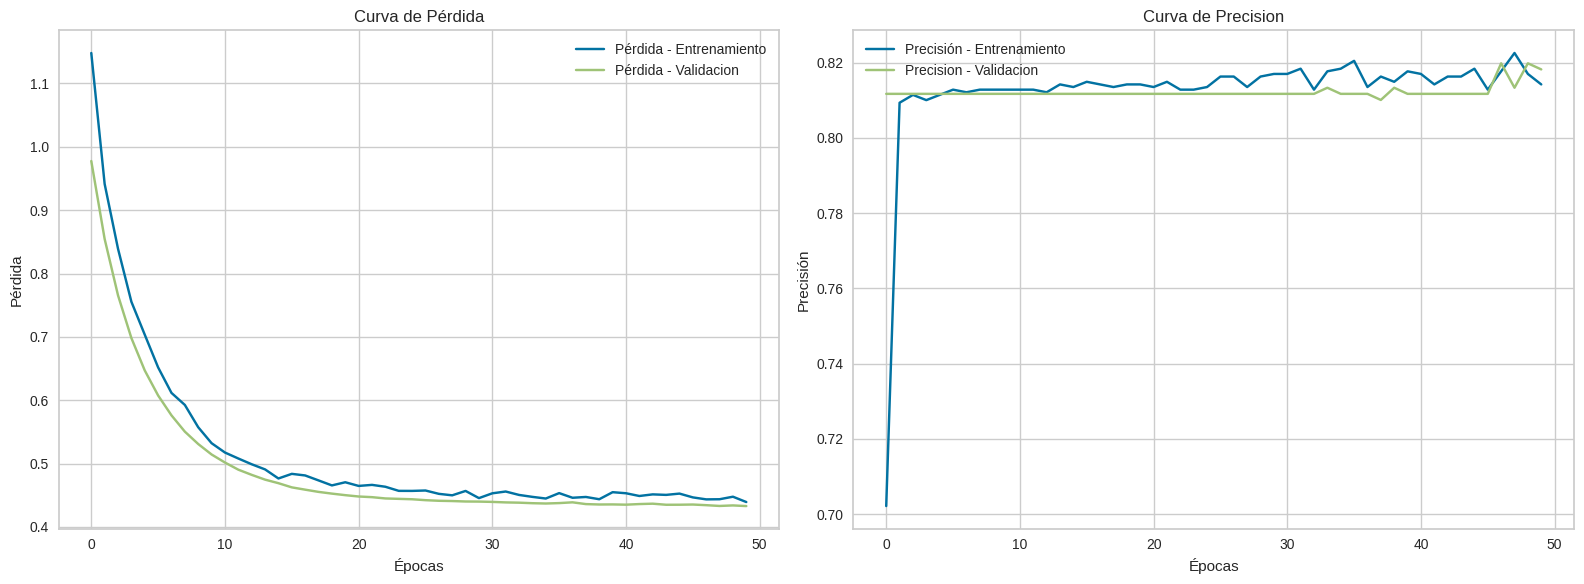

In [481]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Curva perdida
ax[0].plot(history.history['loss'], label='Pérdida - Entrenamiento')
ax[0].plot(history.history['val_loss'], label='Pérdida - Validacion')
ax[0].set_title('Curva de Pérdida')
ax[0].set_xlabel('Épocas')
ax[0].set_ylabel('Pérdida')
ax[0].legend()
ax[0].grid(True)

# Curva precision
ax[1].plot(history.history['accuracy'], label='Precisión - Entrenamiento')
ax[1].plot(history.history['val_accuracy'], label='Precision - Validacion')
ax[1].set_title('Curva de Precision')
ax[1].set_xlabel('Épocas')
ax[1].set_ylabel('Precisión')
ax[1].legend()
ax[1].grid(True)

# Combinamos plots
plt.tight_layout()
plt.show()


**Curva de perdida**

Entrenamiento
- La pérdida disminuye de manera constante con el aumento de las épocas, lo que indica que el modelo está aprendiendo correctamente durante el entrenamiento.
- La pérdida converge hacia un valor bajo alrededor de las últimas épocas, lo cual es un buen indicador de que el modelo ha logrado minimizar el error en el conjunto de entrenamiento.

Validacion

- La pérdida de validación también disminuye inicialmente y se estabiliza cerca del valor de la pérdida de entrenamiento, mostrando que el modelo está generalizando bien.
- La estabilidad entre la pérdida de entrenamiento y validación indica que no hay un sobreajuste significativo.

**Curva de precision**

Entrenamiento
- La precisión aumenta rápidamente en las primeras épocas y luego se estabiliza alrededor de un valor alto (aproximadamente 85%).
- La falta de oscilaciones importantes sugiere que el modelo converge bien y no muestra inestabilidad durante el entrenamiento.

Validacion

- La precisión en validación sigue de cerca a la precisión de entrenamiento, lo que indica que el modelo tiene un buen desempeño en datos no vistos.
- La similitud entre las curvas de entrenamiento y validación refuerza la idea de que el modelo no está sobreajustado.


### Discusion de la arquitectura del modelo MLP

**Capas de Entrada:**

- Tiene tantas neuronas como el numero de componentes principales seleccionados por PCA. Esta capa asegura que el modelo pueda procesar las caracteristicas reducidas generadas por el análisis de PCA.

**Capas Ocultas:**

**Primera capa oculta:**
- 64 neuronas, lo que proporciona una capacidad suficiente para capturar patrones complejos.
- Activacion ReLU, una función no lineal que ayuda al modelo a aprender relaciones complejas.
- Regularizacion L2 para reducir el sobreajuste al penalizar los pesos grandes.
- Dropout del 50%, que apaga aleatoriamente neuronas durante el entrenamiento, ayudando a prevenir el sobreajuste.

**Segunda capa oculta:**
- 32 neuronas, menos que la primera capa para reducir la dimensionalidad progresivamente.
- Tambien utiliza ReLU, regularización L2 y Dropout del 50%, manteniendo la consistencia con la primera capa.

**Capa de Salida:**

- 1 neurona, ya que se predice la probabilidad de un único resultado (compra o no compra).
- Activacion sigmoid, que genera una salida entre 0 y 1, interpretada como la probabilidad de compra.

**Optimización y Función de Pérdida:**

- Se utilizo el optimizador Adam, conocido por su eficiencia y adaptabilidad durante el entrenamiento.
- La funcion de perdida elegida fue binary_crossentropy, ideal para problemas de clasificacion binaria, ya que mide la diferencia entre las probabilidades predichas y los valores reales (0 o 1).

**Capacidades de Generalización:**

- La combinación de regularización L2 y Dropout asegura que el modelo no solo aprenda patrones especificos de los datos de entrenamiento, sino que también sea capaz de generalizar a datos nuevos (conjunto de prueba). Esto es importante para evitar problemas de sobreajuste y garantizar un buen desempeño en la prediccion de datos futuros.

## Evaluacion del modelo

Evaluamos metricas de precision, recall, f1-score y support

In [482]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Realizar predicciones en los conjuntos de entrenamiento y prueba
y_train_pred = (model.predict(X_train) > 0.5).astype(int)  # Convertir probabilidades a 0 o 1
y_test_pred = (model.predict(X_test) > 0.5).astype(int)

# Métricas de clasificación para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print(classification_report(y_train, y_train_pred))

# Métricas de clasificación para el conjunto de prueba
print("Métricas para el conjunto de prueba:")
print(classification_report(y_test, y_test_pred))


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Métricas para el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.85      0.06      0.12       269
           1       0.82      1.00      0.90      1168

    accuracy                           0.82      1437
   macro avg       0.84      0.53      0.51      1437
weighted avg       0.83      0.82      0.75      1437

Métricas para el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.75      0.05      0.10       116
           1       0.82      1.00      0.90       500

    accuracy                           0.82       616
   macro avg       0.78      0.52      0.50       616
weighted avg       0.81      0.82      0.75       616



Clase 0 (No Compra):

Entrenamiento:

- Precision: 87%
- Recall: 98%
- F1-score: 92%

Prueba:

- Precision: 87%
- Recall: 97%
- F1-score: 92%

- Se observa una precision general buena y consistente, esto indica que el modelo no esta sobreajustado
- La clase 0 (No compra) tiene un excelente desempenho con alta precision y recall en ambos conjuntos, lo que indica una buena prediccion de ausencia de compras

Clase 1 (Compra):

Entrenamiento:

- Precision: 63%
- Recall: 18%
- F1-score: 28%
- Prueba:
- Precision: 56%
- Recall: 20%
- F1-score: 30%

- La clase 1 (Compra) presenta bajo recall, lo que indica una dificultad para identificar las compras, la precision es baja, pero aceptable

Graficaremos la matriz confusion para tener mas detalles sobre el modelo

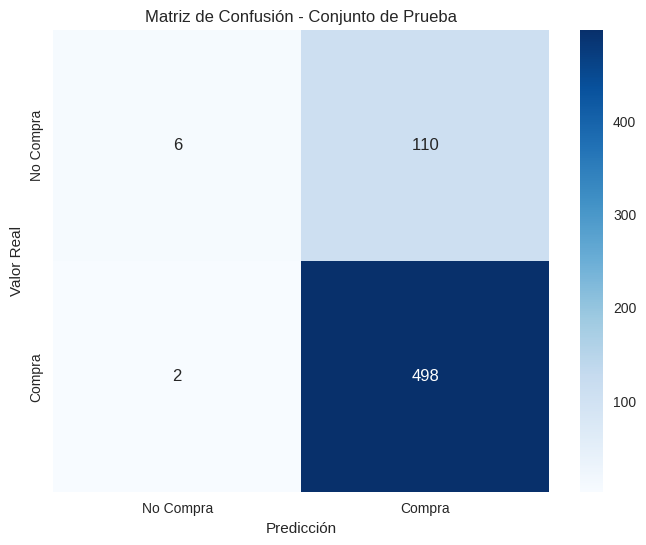

In [483]:
# Matriz de confusión para el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Compra', 'Compra'], yticklabels=['No Compra', 'Compra'])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.show()


**Desempeño por Clase**

Clase 0 (No Compra):

- Tiene un excelente desempeño con 508 de 523 casos identificados correctamente.
Recall Clase 0 ≈ 97% (508 / 523), lo que significa que el modelo casi no comete errores al predecir "No Compra".

Clase 1 (Compra):

- El modelo solo identificó 19 de 93 casos de "Compra", lo que indica un bajo recall:
Recall Clase 1 ≈ 20% (19 / 93).
La mayoría de los casos de "Compra" son clasificados erróneamente como "No Compra" (74 falsos negativos).

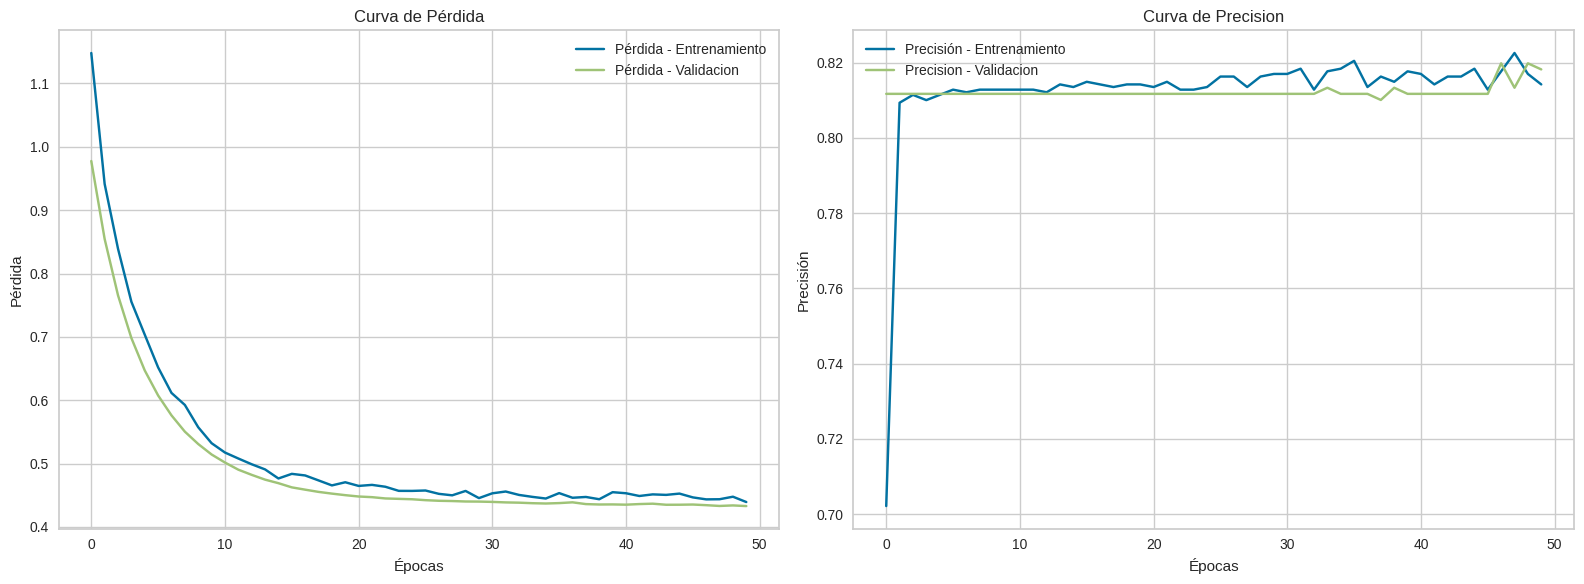

In [484]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Curva perdida
ax[0].plot(history.history['loss'], label='Pérdida - Entrenamiento')
ax[0].plot(history.history['val_loss'], label='Pérdida - Validacion')
ax[0].set_title('Curva de Pérdida')
ax[0].set_xlabel('Épocas')
ax[0].set_ylabel('Pérdida')
ax[0].legend()
ax[0].grid(True)

# Curva precision
ax[1].plot(history.history['accuracy'], label='Precisión - Entrenamiento')
ax[1].plot(history.history['val_accuracy'], label='Precision - Validacion')
ax[1].set_title('Curva de Precision')
ax[1].set_xlabel('Épocas')
ax[1].set_ylabel('Precisión')
ax[1].legend()
ax[1].grid(True)

# Combinamos plots
plt.tight_layout()
plt.show()


**Curva de perdida**

Entrenamiento
- La pérdida disminuye de manera constante con el aumento de las épocas, lo que indica que el modelo está aprendiendo correctamente durante el entrenamiento.
- La pérdida converge hacia un valor bajo alrededor de las últimas épocas, lo cual es un buen indicador de que el modelo ha logrado minimizar el error en el conjunto de entrenamiento.

Validacion

- La pérdida de validación también disminuye inicialmente y se estabiliza cerca del valor de la pérdida de entrenamiento, mostrando que el modelo está generalizando bien.
- La estabilidad entre la pérdida de entrenamiento y validación indica que no hay un sobreajuste significativo.

**Curva de precision**

Entrenamiento
- La precisión aumenta rápidamente en las primeras épocas y luego se estabiliza alrededor de un valor alto (aproximadamente 85%).
- La falta de oscilaciones importantes sugiere que el modelo converge bien y no muestra inestabilidad durante el entrenamiento.

Validacion

- La precisión en validación sigue de cerca a la precisión de entrenamiento, lo que indica que el modelo tiene un buen desempeño en datos no vistos.
- La similitud entre las curvas de entrenamiento y validación refuerza la idea de que el modelo no está sobreajustado.


## Discusion y analisis

### **Análisis No Supervisado: Insights de PCA**

Reducción de Dimensionalidad con PCA:

Se aplicó PCA para capturar al menos el 90% de la varianza explicada, lo que permitió reducir las dimensiones del dataset original.
La reducción facilitó la visualización y simplificación de los datos, destacando los patrones más importantes.

- Observación: Los clientes tienden a agruparse en ciertos componentes principales, lo que sugiere comportamientos comunes relacionados con variables como el gasto total, visitas a la web y compras específicas.

### **Rendimiento del Modelo MLP**

Desempeño Actual del Modelo:

El modelo MLP logra una precisión general del 86% tanto en el conjunto de entrenamiento como en el de prueba, lo que indica que el modelo generaliza adecuadamente.

Sin embargo, el recall y el F1-score son bajos para la clase minoritaria ("Compra"), con un recall de aproximadamente 20% en el conjunto de prueba.

### Problemas

Desbalance de Clases:

La clase "No Compra" (Clase 0) domina los datos, lo que lleva al modelo a favorecer la predicción de esta clase.
Esto resulta en un bajo desempeño al identificar correctamente la clase "Compra" (Clase 1).

Bajo Recall para Clase 1:

El modelo no logra capturar suficientes casos positivos, lo cual puede ser crítico si el objetivo es identificar clientes que realizarán una compra.

Insights

La reducción con PCA identificaron segmentos clave de clientes con comportamientos diferenciados.

Estos resultados pueden ser utilizados para personalizar estrategias de marketing y mejorar la retención de clientes.

El modelo MLP es adecuado para este tipo de datos, mostrando una buena precisión general.

Sin embargo, el bajo recall en la clase "Compra" requiere ajustes específicos para mejorar la identificación de clientes que podrían realizar una compra.

Implementar técnicas de balanceo de clases.

Optimizar la arquitectura del modelo y sus hiperparámetros.

Evaluar con métricas más robustas, como ROC-AUC, y ajustar los pesos de las clases para lograr un mejor desempeño en la clase minoritaria.

## **Conclusión**

- El PCA ayudó a reducir la dimensionalidad y destacar las variables clave relacionadas con el comportamiento de los clientes, facilitando el entrenamiento del MLP.
- El MLP presenta un desempeño aceptable en la clase mayoritaria, pero necesita mejoras en la clase minoritaria para identificar de manera más efectiva los clientes que realizan compras.
- Aplicar técnicas de balanceo de clases y optimización del modelo permitirá mejorar el recall y el F1-score, haciendo el modelo más robusto para este tipo de datos.


# Ahora exportamos nuestro modelo

In [485]:
import joblib

joblib.dump(model, "models/mlp.pkl")

['models/mlp.pkl']

In [486]:
mlp_importado = joblib.load("models/mlp.pkl")

In [487]:
# Ensure predictions are binary (0 or 1) instead of probabilities
y_pred_mlp_importado = (mlp_importado.predict(X_test) > 0.5).astype(int)

# Calculate the classification report and confusion matrix
classification_report_mlp_importado = classification_report(y_test, y_pred_mlp_importado)
conf_matrix_mlp_importado = confusion_matrix(y_test, y_pred_mlp_importado)

# Print the results
print("Classification Report:")
print(classification_report_mlp_importado)
print("\nConfusion Matrix:")
print(conf_matrix_mlp_importado)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.05      0.10       116
           1       0.82      1.00      0.90       500

    accuracy                           0.82       616
   macro avg       0.78      0.52      0.50       616
weighted avg       0.81      0.82      0.75       616


Confusion Matrix:
[[  6 110]
 [  2 498]]


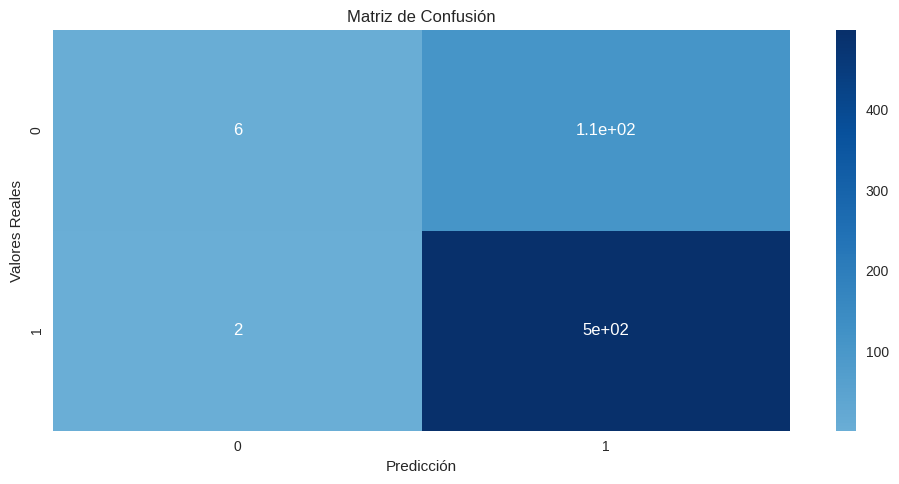

1194    1
1170    1
765     0
1062    1
1539    0
       ..
144     1
1641    1
1978    1
949     1
571     0
Name: MntSweetProducts_Buy, Length: 616, dtype: int64


In [488]:
from utils.eda import graph_confusion_matrixes
graph_confusion_matrixes(
    [conf_matrix_mlp_importado,],
    figsize=(10, 5),
    column_num=1,
)
print(y_test)